<a href="https://colab.research.google.com/github/samkirwanppb/UCDPA_SamKirwan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##importing all packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") ### might have to put this into the function below. we will see in time. 
sns.color_palette("Spectral", as_cmap=True) #this changes the relplot, hue is different in the lm plot
sns.set()

# Data Gathering/Cleaning

In [3]:
##the ratings data set contains the current ratings of all horses trained in Great Britain
ratings = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/ratings.csv')
ratings = ratings.iloc[:, :-7] 
ratings['rating_final'] = ratings[['Flat rating', 'AWT rating']].max(axis = 1) #gets the max rating of the 2 available ratings for a horse and creats and new column
ratings.loc[ratings['Flat rating'].notnull() & ratings['AWT rating'].notnull()].head() #the column on the right contains the max of the 2 columns that we are interested in.

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,rating_final
34,ABOVE (FR),2017,GELDING,ANJAAL (GB),BROKEN APPLAUSE (IRE),Stuart Williams,89.0,NaN,NaN,94.0,NaN,94.0
155,AIR RAID (GB),2015,GELDING,RAVEN'S PASS (USA),SIREN SOUND (GB),NaN,94.0,NaN,NaN,89.0,NaN,94.0
182,AL KOUT (GB),2014,GELDING,OASIS DREAM (GB),HONORLINA (FR),NaN,61.0,NaN,NaN,67.0,NaN,67.0
196,AL ZARAQAAN (GB),2017,GELDING,GOLDEN HORN (GB),ASHEERAH (GB),Archie Watson,87.0,NaN,NaN,102.0,NaN,102.0
204,ALBA DEL SOLE (IRE),2015,FILLY,DANDY MAN (IRE),WINTERWELL (USA),NaN,49.0,NaN,NaN,42.0,NaN,49.0


In [4]:
ratings = ratings.drop(columns = {'Diff Flat', 'Flat Clltrl', 'Diff AWT', 'Flat rating', 'AWT rating'}) #removing unwanted columns
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0


In [5]:
###will use the above data to see how many horses a particular trainer has in training. this metric will also be used to predict horse ability. 
trainer = pd.DataFrame()

trainer = ratings.groupby('Trainer')['Name'].count().rename('trainer_horses').reset_index()
trainer.head()

,Trainer,trainer_horses
0,A C Wilson,1
1,A. B. Leyshon,2
2,Adam Nicol,8
3,Adam West,25
4,Adrian Keatley,19


In [6]:
ratings_trainer = ratings.merge(trainer, on = 'Trainer', how = 'left')
ratings_trainer.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,69.0
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,90.0
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN


In [7]:
##performance_ratings will be used to see if a horse has had 1,2,3,4,5 or 6+ runs
performance_figures = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/performance_figures.csv')
##remove National Hunt ratings. #meh will come back to it, not sure will I need this table really. 
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,T:73,T:79,T:72,T:63,T:74,T:80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,A:42,T:47,T:x,T:x,T:x,-
2,A DEFINITE GETAWAY (IRE),2018,GELDING,Ben Pauling,H:x,H:x,H:x,-,-,-
3,A DIFFERENT KIND (IRE),2017,GELDING,Donald McCain,H:93,H:135,H:x,H:x,H:x,H:x
4,A E HOUSMAN (GB),2019,COLT,NaN,T:71,A:x,A:x,T:x,T:x,-


In [8]:
##this function is used to remove the unwanted charactors from the df.
def clean_peformance_figures(data, column):  
  data = data[~data[column].str.contains("H")]
  data = data[~data[column].str.contains("S")]
  data = data[~data[column].str.contains("N")]
  data[column] = data[column].str.replace(":","").str.replace("T", "").str.replace("A","")
  return data

#this for loop iterates through the last 6 columns of the data and passes them into the function created to clean the columns.
for i in performance_figures.columns[-6:]:
  performance_figures = clean_peformance_figures(performance_figures, i)

performance_figures = performance_figures.replace("-", np.nan)
performance_figures['runs'] = 6 - performance_figures.iloc[:,-6:].isna().sum(axis = 1)
performance_figures.head() #we havce succesfully created the runs column which will be used in the model. 

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4


In [9]:
##I have merged ratings and the columns I want from peformance figures here
ratings_merged = ratings_trainer.merge(performance_figures[['Racehorse', 'runs']], left_on = 'Name', right_on = 'Racehorse').drop(columns = 'Racehorse')
ratings_merged.loc[(~ratings_merged['rating_final'].isna()) & (ratings_merged['runs'] <= 2), 'runs'] = np.nan ##this removes funny examples where horses where imported into GB already with a rating
ratings_merged.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0


In [10]:
yearling_sales = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales.csv').drop(columns = 'Purchaser')
yearling_sales.head()

,Year Foaled,Sire,Dam,Sex,Consignor,Price (€),Price (£),Price (gns)
0,2020.0,Lope de Vega (IRE),Ebeyina (IRE),Colt,Ballylinch Stud,130000.0,NaN,NaN
1,2020.0,U S Navy Flag (USA),Edelline (IRE),Colt,Lynn Lodge Stud,36000.0,NaN,NaN
2,2020.0,Holy Roman Emperor (IRE),Elaysa (GB),Colt,Redpender Stud,90000.0,NaN,NaN
3,2020.0,No Nay Never (USA),Eldalil (GB),Filly,Oaks Farm Stables,85000.0,NaN,NaN
4,2020.0,Churchill (IRE),Elizabelle (IRE),Filly,Baroda Stud,60000.0,NaN,NaN


In [11]:
#Data cleansing to merge into the main dataframe
yearling_sales['Sire'] = yearling_sales['Sire'].str.upper()
yearling_sales['Dam'] = yearling_sales['Dam'].str.upper()
yearling_sales['Sex'] = yearling_sales['Sex'].str.upper()
yearling_sales = yearling_sales.dropna(subset = ['Year Foaled'])
yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)

##going to get them all in the one currency
yearling_sales.loc[~yearling_sales['Price (€)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (€)'].isna()]['Price (€)'] * 0.88
yearling_sales.loc[~yearling_sales['Price (gns)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (gns)'].isna()]['Price (gns)'] * 1.05
yearling_sales.loc[~yearling_sales['Price (£)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (£)'].isna()]['Price (£)'] * 1
yearling_sales = yearling_sales.drop(columns = ['Price (€)', 'Price (£)', 'Price (gns)'])
yearling_sales.head()

,Year Foaled,Sire,Dam,Sex,Consignor,final_price
0,2020,LOPE DE VEGA (IRE),EBEYINA (IRE),COLT,Ballylinch Stud,114400.0
1,2020,U S NAVY FLAG (USA),EDELLINE (IRE),COLT,Lynn Lodge Stud,31680.0
2,2020,HOLY ROMAN EMPEROR (IRE),ELAYSA (GB),COLT,Redpender Stud,79200.0
3,2020,NO NAY NEVER (USA),ELDALIL (GB),FILLY,Oaks Farm Stables,74800.0
4,2020,CHURCHILL (IRE),ELIZABELLE (IRE),FILLY,Baroda Stud,52800.0


In [12]:
ratings_final_sale = ratings_merged.merge(yearling_sales.drop(columns = ['Sex','Consignor']), left_on = ['Sire', 'Dam', 'Year'], right_on = ['Sire', 'Dam', 'Year Foaled'], how = 'left')
ratings_final_sale = ratings_final_sale.drop(columns = 'Year Foaled')
ratings_final_sale.head()##note final price is in £

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN


In [13]:
yearling_sales_sires = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales_sires.csv')
median_yearling_sales = yearling_sales_sires.loc[yearling_sales_sires['year'] == 2022][['Stallion', 'Med. £']]
median_yearling_sales.head() ##the stallion name is formated different to the ratings_final_sale df which I will have to clean in order to merge

,Stallion,Med. £
0,Dubawi,"669,375"
3,Frankel,"338,123"
4,Kingman,"283,500"
5,Galileo,"259,307"
7,Siyouni,"181,741"


In [14]:
ratings_final_sale['sire_merge'] = ratings_final_sale['Sire'].str.split("(").str[0].str.strip().str.capitalize()
ratings_final_sale.head() #sire_merge can be used to merge the above df into the main one

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay


In [15]:
merged_data = ratings_final_sale.merge(median_yearling_sales, left_on = 'sire_merge', right_on = 'Stallion', how = 'left').replace(',','', regex=True)
merged_data = merged_data.drop(columns = ['Stallion']).rename(columns = {'Med. £' : 'Sire_median_yearling_price'})#makes the median price more readable
merged_data.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023


# Data Cleaning / Web Scraping


In [16]:
###start of scraping the below site was found after inspecting the irish field website
hsite = "https://e.infogram.com/_/bQHbMUkcBdD1LFGscrW5?parent_url=https%3A%2F%2Fwww.theirishfield.ie%2Fstallion-fees-up-to-date-fees-for-more-than-400-stallions-for-2023-738173&src=embed#async_embed"
res = requests.get(hsite)
soup = bs(res.content, "html.parser")
#soup


x = soup.find_all("script")[4]
## really good use of regex here i think to get the data from there.

string = str(x)
print(string[0:2000])###dont print all of it, looks bad in github

<script>window.infographicData={"id":318959736,"type":0,"block_id":"023467ec-1db7-4ba5-90b3-12e78f43dcf4","theme_id":258,"user_id":2114665,"team_user_id":805284,"path":"a0ff400d-32c4-4e46-bde8-a093a04e1b11","title":"Stallion fees 2023 wk48","description":"","tags":"","public":false,"publicAccess":false,"private_link_enabled":1,"thumb":"https:\u002F\u002Finfogram-thumbs-200.s3-eu-west-1.amazonaws.com\u002F023467ec-1db7-4ba5-90b3-12e78f43dcf4.jpg","embedImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F6c657eaada927282c6ba8f94485caba4.png","previewImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F90c07788e8331dd681e583525fa6ab72.png","width":599,"copyright":"","properties":{"tabs":true,"custom_logo":"none","embed_button":"disabled","transparent":true,"zeropaddingembed":"true","title_link":"infogram","customLinkOption":"text","footerSettings":{},"publishType":1,"rtl":false,"language":"en","export_settings":{"showGrid":true,"showValues":true},"whitelabel":true,"noTracking":false,"dec

In [17]:
raw_data = re.findall(r'\[(.*?)\]', string)


##the below is a reusable function. When inputting the list returned from the regex pattern this will return the desired elements that we would like to keep
def clean_data(data):
  data_filtered = []
  for i in data:
    if len(i) != 0: ##removes empty strings in the list 
        if i[0] == '"' and i[-2:] == ')"': ##these are the charactorists of the strings that we want to keep.
            i = i.replace('"', '')#removing all the "'s from the data
            data_filtered.append(i)

  return data_filtered

data_lst = clean_data(raw_data)

print(data_lst[0:5])

['Acclamation,Rathbarry,€27,500 (€27,500)', 'Alkumait,Castlefield,€5,000 (€5,000)', 'Arizona,Coolmore,€5,000 (€6,000)', 'Australia,Coolmore,€25,000 (€35,000)', 'Awtaad,Derrinstown,€5,000 (€5,000)']


In [18]:
data_dic = {}
for i in data_lst:
  data_dic[i.split(",", 2)[0]] = [i.split(",", 2)[1],i.split(",", 2)[2]]

col = ['Sire','Stud', 'Fee']
fee_data = pd.DataFrame.from_dict(data_dic, orient='index').reset_index()
fee_data.set_axis(col, axis = 1, inplace = True)
fee_data.head()

,Sire,Stud,Fee
0,Acclamation,Rathbarry,"€27,500 (€27,500)"
1,Alkumait,Castlefield,"€5,000 (€5,000)"
2,Arizona,Coolmore,"€5,000 (€6,000)"
3,Australia,Coolmore,"€25,000 (€35,000)"
4,Awtaad,Derrinstown,"€5,000 (€5,000)"


In [19]:
##cleaning the fee column. the first price is the 2023 years fee, the price in brackets is the 2022 fee (last year)
fee_data['Fee 2023'] = fee_data['Fee'].str.split("(").str[0].str.strip()
fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('A\$'))]#remove australian stallions, had to use the escape charactor for the dollar sign, in plain english we are removing strings containing A$
fee_data = fee_data.loc[~(fee_data['Fee'].str.contains('Private'))]
fee_data.head()

<ipython-input-19-424f868148fe>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")


,Sire,Stud,Fee,Fee 2023,Fee 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","€27,500","€27,500"
1,Alkumait,Castlefield,"€5,000 (€5,000)","€5,000","€5,000"
2,Arizona,Coolmore,"€5,000 (€6,000)","€5,000","€6,000"
3,Australia,Coolmore,"€25,000 (€35,000)","€25,000","€35,000"
4,Awtaad,Derrinstown,"€5,000 (€5,000)","€5,000","€5,000"


In [20]:
fee_data['Fee 2022'].value_counts().head() ##shows this akward that is there as new

NEW        34
€5,000     22
$10,000    16
€15,000    10
€4,000      9
Name: Fee 2022, dtype: int64

In [21]:
#replacing the new value with nans
fee_data['Fee 2022'] = fee_data['Fee 2022'].replace('NEW', np.nan)
fee_data['Fee 2022'].value_counts().head()#new is gone and replaced with NP.nan

€5,000     22
$10,000    16
€15,000    10
€4,000      9
$15,000     8
Name: Fee 2022, dtype: int64

In [22]:
##careful reruning this, if no fee has changed currency can use the following - fee_data[['Currency 2023', 'Currency 2022']] = fee_data['Fee'].str[0] 
##as can be seen in the above code the fee columns still need some cleaning. also an important observation is that the currencyies for the fees are different for certain stallions
#so I will create a column that stores the currencies so that we can convert them all into the one
fee_data['Currency 2023'] = fee_data['Fee 2023'].str[0] 
fee_data['Currency 2022'] = fee_data['Fee 2022'].str[0]
#clean the Fee 2022 and Fee 2023 columns so that they are ints
fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data = fee_data.replace(',','', regex=True)


<ipython-input-22-a1469e21d690>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
<ipython-input-22-a1469e21d690>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")


In [23]:
fee_data[['Fee 2022','Fee 2023']] = fee_data[['Fee 2022','Fee 2023']].astype(float)

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '€'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.88
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '€'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.88

fee_data.loc[(~fee_data['Fee 2023'].isna()) & (fee_data['Currency 2023'] == '$'), 'Fee_2023_final'] = fee_data.loc[~fee_data['Fee 2023'].isna()]['Fee 2023'] * 0.83
fee_data.loc[(~fee_data['Fee 2022'].isna()) & (fee_data['Currency 2022'] == '$'), 'Fee_2022_final'] = fee_data.loc[~fee_data['Fee 2022'].isna()]['Fee 2022'] * 0.83

fee_data[['Fee 2022', 'Fee 2023']] = fee_data[['Fee 2022', 'Fee 2023']].fillna(0).astype(int).replace(0, np.nan)
fee_data.head() #have clean data scraped from the web in the formate that we require

,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,Fee_2023_final,Fee_2022_final
0,Acclamation,Rathbarry,€27500 (€27500),27500,27500.0,€,€,24200.0,24200.0
1,Alkumait,Castlefield,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0
2,Arizona,Coolmore,€5000 (€6000),5000,6000.0,€,€,4400.0,5280.0
3,Australia,Coolmore,€25000 (€35000),25000,35000.0,€,€,22000.0,30800.0
4,Awtaad,Derrinstown,€5000 (€5000),5000,5000.0,€,€,4400.0,4400.0


In [24]:
fee_data = fee_data[['Sire', 'Fee_2023_final']]#keeping the columns we need for the main data set
fee_data.head()

,Sire,Fee_2023_final
0,Acclamation,24200.0
1,Alkumait,4400.0
2,Arizona,4400.0
3,Australia,22000.0
4,Awtaad,4400.0


In [25]:
##have moved down here for when i merge in sire fee
data = merged_data.merge(fee_data, left_on = 'sire_merge', right_on = 'Sire', how = 'left').drop(columns = 'Sire_y').rename(columns = {'Sire_x': 'Sire'})
data.head() ##we now have a clean data set containing all the columns from each data set that we desire.            

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price,Fee_2023_final
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023,4400.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023,4400.0


In [26]:
data.shape

(7478, 13)

# Dataset Description/Overview

In [27]:
##do some descriptive stuff here off final dataset
data.shape

(7478, 13)

In [35]:
data.isna().sum()

Name                             0
Year                             0
Sex                              0
Sire                             0
Dam                              0
Trainer                       2503
rating_final                    20
trainer_horses                2503
runs                           138
final_price                   4808
sire_merge                       0
Sire_median_yearling_price    4581
Fee_2023_final                6023
dtype: int64

In [73]:
#data.loc[(data['final_price'].isnull()) & (data['Year'] >= 2018)][['Name', 'final_price', 'Year']].head(20)

,Name,final_price,Year
2,A E HOUSMAN (GB),NaN,2019
4,A LADY FOREVER (GB),NaN,2019
7,A TASTE OF HONEY (GB),NaN,2020
10,AASSER (FR),NaN,2019
16,ABDUCTION (FR),NaN,2018
20,ABIE MY BOY (GB),NaN,2019
30,ABSOLUTE RULER (USA),NaN,2019
32,ABSTRACT (IRE),NaN,2018
34,ACADIAN CITY (GB),NaN,2019
36,ACCELERANDO (IRE),NaN,2019


In [86]:
###Sire_median_yearling_price would be an educated guess as to what the horse made and could be a good part of prepoccing data #also bring in trainer avg.
avg_trainer_price = data.groupby('Trainer')['final_price'].agg({'mean', 'count'}).rename(columns = {'mean':'mean_trainer_price', 'count': 'count_trainer_price'})
avg_trainer_price.head(), avg_trainer_price.shape, avg_trainer_price.loc[avg_trainer_price['count_trainer_price'] > 5].shape ##come up with a plan on trainer avg here. will merge in below.

(                 mean_trainer_price  count_trainer_price
 Trainer                                                 
 Adam Nicol             31500.000000                    1
 Adam West              79645.000000                    6
 Adrian Keatley         21742.857143                    7
 Adrian Nicholls        27195.000000                    6
 Adrian Wintle          32156.666667                    6, (381, 2), (109, 2))

In [87]:
data_df = data.merge(avg_trainer_price, how = 'left', on = 'Trainer')
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,FILLY,GELDING,mean_trainer_price,count_trainer_price
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,0,1,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023,4400.0,0,1,6095.0,5.0
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN,NaN,0,0,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074,NaN,1,0,45062.5,8.0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023,4400.0,1,0,25994.0,10.0


In [99]:
data_df['final_price_est'] = data_df.loc[data_df['final_price'].isna()][['mean_trainer_price', 'Sire_median_yearling_price']].mean(axis=1) ##sire_median_yearling price is the wrong data type.
data_df.isna().sum()

IntCastingNaNError: ignored

In [96]:
data_df[['mean_trainer_price', 'Sire_median_yearling_price']].astype(int).mean(axis=1) #currently returns a nan for animals without either of the 2 columns. will have to fix that
##also would prefer to 

0                NaN
1        7559.000000
2                NaN
3       25568.250000
4       17508.500000
            ...     
7473             NaN
7474    19866.000000
7475    25663.333333
7476    21625.000000
7477    52500.000000
Length: 7478, dtype: float64

In [98]:
data_df.loc[data_df['final_price'].isna()].head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,FILLY,GELDING,mean_trainer_price,count_trainer_price,final_price_est
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN,NaN,0,0,NaN,NaN,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023,4400.0,1,0,25994.0,10.0,25994.0
6,A SURE WELCOME (GB),2014,GELDING,PASTORAL PURSUITS (GB),CROESO BACH (GB),John Spearing,80.0,8.0,6.0,NaN,Pastoral pursuits,NaN,NaN,0,1,22100.0,2.0,22100.0
7,A TASTE OF HONEY (GB),2020,FILLY,HARRY ANGEL (IRE),GIMME SOME LOVIN (IRE),Archie Watson,76.0,48.0,3.0,NaN,Harry angel,NaN,NaN,1,0,82347.5,16.0,82347.5
8,AADDEEY (IRE),2017,GELDING,NEW APPROACH (IRE),FEEDYAH (USA),Archie Watson,101.0,48.0,6.0,NaN,New approach,NaN,NaN,0,1,82347.5,16.0,82347.5


In [83]:
data_df.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,FILLY,GELDING,mean,count,final_price_est
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,0,1,NaN,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023,4400.0,0,1,6095.0,5.0,NaN
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN,NaN,0,0,NaN,NaN,NaN
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074,NaN,1,0,45062.5,8.0,NaN
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023,4400.0,1,0,25994.0,10.0,NaN


In [43]:
data[['FILLY', 'GELDING']] = pd.get_dummies(data['Sex'], drop_first = True)
data.head()

,Name,Year,Sex,Sire,Dam,Trainer,rating_final,trainer_horses,runs,final_price,sire_merge,Sire_median_yearling_price,Fee_2023_final,FILLY,GELDING
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,6.0,6160.0,Markaz,NaN,NaN,0,1
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,14.0,5.0,4725.0,Adaay,9023,4400.0,0,1
2,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,5.0,NaN,Oasis dream,NaN,NaN,0,0
3,A LA FRANCAISE (GB),2019,FILLY,POSTPONED (IRE),ALAMODE (GB),Jim Goldie,71.0,41.0,6.0,52500.0,Postponed,6074,NaN,1,0
4,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,35.0,4.0,NaN,Adaay,9023,4400.0,1,0


In [77]:
data_df = data[['rating_final', 'Year', 'trainer_horses', 'runs', 'final_price', 'Sire_median_yearling_price', 'FILLY', 'GELDING']].dropna()

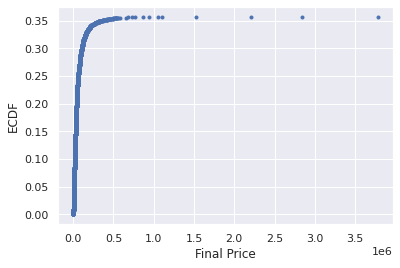

In [28]:
##ecf function taken from datacamp module
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y
  
  # Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['final_price'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('Final Price')
plt.ylabel('ECDF')

# Display the plot
plt.show()

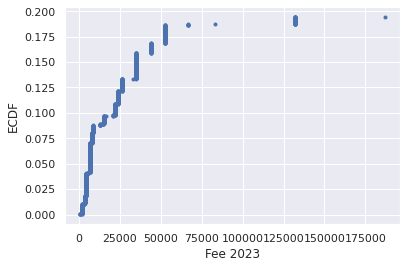

In [29]:
x_vers, y_vers = ecdf(data['Fee_2023_final'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('Fee 2023')
plt.ylabel('ECDF')

# Display the plot
plt.show()

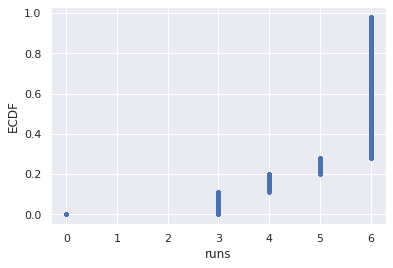

In [30]:
x_vers, y_vers = ecdf(data['runs'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('runs')
plt.ylabel('ECDF')

# Display the plot
plt.show()

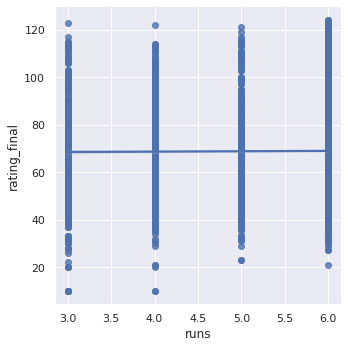

In [31]:
sns.lmplot(data = data, x = 'runs', y = 'rating_final')

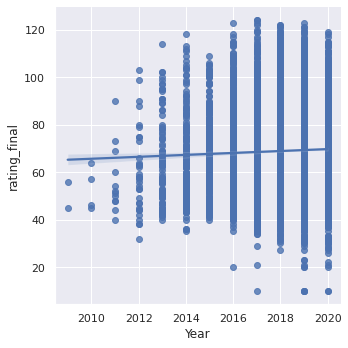

In [32]:
sns.lmplot(data = data, x = 'Year', y = 'rating_final') ## this will need a better model/visualisation 2022 should be a touch below 2019 and 2018

# Modeling

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
y = data_df['rating_final']
X = data_df[['Year', 'trainer_horses', 'runs', 'final_price', 'Sire_median_yearling_price', 'FILLY', 'GELDING']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))
print(reg.coef_)

Predictions: [71.25212889 73.98624924], Actual Values: 6077    67.0
5262    81.0
Name: rating_final, dtype: float64
[-2.21957476e+00  7.42893937e-02  1.38259998e+00  1.21987352e-05
  9.39871140e-06 -1.40930694e+01 -1.14363433e+01]


In [52]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.22143930164693415
RMSE: 14.436401005289039


In [54]:
# Import the necessary modules
from sklearn.model_selection import KFold, cross_val_score

# Create a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=5)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

# Print scores
print(cv_scores)

[ 0.23206065  0.17512414  0.22516272  0.23626878 -0.96865145  0.12128607]


In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')
# path = '/content/drive/My Drive/output_5.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   fee_data.to_csv(f)

# ###very handy bit of code.

In [ ]:
#i think the goal here will be to predict 2023 stallion prices based on 2022 sales results, horses abilitie and 2022 fee? stud could be good too, just trying to flesh it out a bit. might get the basic sracper out if needing more data 
#we will use the 2021 sale data and whatever horses we have from 2021 to predict 2022 prices then use the findings to predict 2023 prices.  

##another goal and one to defo do is get trainer stable size using the rating csv. good use of groupby